# Backward Propagation with Mini-Batch Stochastic Gradiant Descent

## Spesifikasi
- Jumlah hidden layer maksimal 10
- Jumlah node dalam setiap hidden layer dapat bervariasi
- Fully-connected layer
- Fungsi aktivasi berupa sigmoid untuk semua hidden layer maupun output layer
- Node output berjumlah 1
- Program memberikan pilihan untuk menggunakan momentum atau tidak
- Program mengimplementasikan mini-batch stochastic gradient descent
- Implementasi incremental dengan setting batch-size=1 dan implementasi batch dengan setting batchsize=jumlah
data.

Algoritma ini akan diuji dengan data weather (tennis) yang diambil dari Weka

In [2]:
from scipy.io import arff
import numpy as np
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [45]:
class NeuralNetwork():
    def __init__(self, 
                 input_nodes,
                 hidden_nodes=[],
                 output_nodes=1,
                 batch_size=4,
                 learning_rate=1e-4,
                 momentum=0,
                 threshold=0.5):
        assert(input_nodes >= 1)
        assert(0 <= len(hidden_nodes) <= 10)
        assert(batch_size >= 1)
        
        self.layers = self._init_layers(input_nodes, hidden_nodes, output_nodes)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.threshold = threshold
        
        self.params_values = self._init_weights()

        
    def _init_layers(self, input_nodes, hidden_nodes, output_nodes):
        layers = []
        layers.append(input_nodes)
        for hidden_layer in hidden_nodes:
            layers.append(hidden_layer)
        layers.append(output_nodes)
        
        return layers
    
    def _init_grads_values(self):
        grads_values = {}
        for idx in range(1, len(self.layers)):
            layer_input_size = self.layers[idx-1]
            layer_output_size = self.layers[idx]
            grads_values['W' + str(idx)] = np.zeros([layer_output_size, layer_input_size])
            grads_values['b' + str(idx)] = np.zeros([layer_output_size])
        return grads_values
        
    def _init_weights(self):
        """
        Initiate weights and bias weights for the neural network
        """
        params_values = {}
        for idx in range(len(self.layers)-1):
            layer_input_size = self.layers[idx]
            layer_output_size = self.layers[idx+1]
            
            # Weight
            params_values['W' + str(idx+1)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            
            # Bias Weight
            params_values['b' + str(idx+1)] = np.random.randn(layer_output_size) * 0.1
            
#         print(params_values)
        return params_values
    
    
    def _single_layer_feed_forward(self, A_prev, W_curr, b_curr):
        """
        Feed forward for single layer in neural network
        """
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        return self._sigmoid(Z_curr), Z_curr
        
        
    def _full_feed_forward(self, X):
        memory = {}
        A_curr = X
        
        for idx in range(len(self.layers)-1):
            A_prev = A_curr
            
            W_curr = self.params_values['W' + str(idx+1)]
            b_curr = self.params_values['b' + str(idx+1)]
            
            A_curr, Z_curr = self._single_layer_feed_forward(A_prev, W_curr, b_curr)
            
            memory['A' + str(idx)] = A_prev
            memory['Z' + str(idx+1)] = Z_curr
            
        memory['A' + str(len(self.layers)-1)] = A_curr
        return A_curr, memory
        
    
    def _single_layer_backward_prop(self, dA_curr, W_curr, b_curr, Z_curr, A_prev):
        
        dZ_curr = dA_curr * self._sigmoid_backward(Z_curr)
        dW_curr = np.outer(dZ_curr, A_prev)
        db_curr = dZ_curr
        dA_prev = np.dot(W_curr.T, dZ_curr)
        
        return dA_prev, dW_curr, db_curr
    
    
    def _full_backward_prop(self, y_hat, y, memory):
        grads_values = {}
        
        dA_curr = y - y_hat

#         print('backprop y: {}, y_hat: {}'.format(y, y_hat))
        
        for layer_idx_prev in range(len(self.layers)-2, -1, -1):
            layer_idx_curr = layer_idx_prev + 1
            
#             print('layer_idx_curr: {}, layer_idx_prev: {}'.format(layer_idx_curr, layer_idx_prev))
            
            A_curr = memory['A' + str(layer_idx_curr)]
            A_prev = memory['A' + str(layer_idx_prev)]
            Z_curr = memory['Z' + str(layer_idx_curr)]
            W_curr = self.params_values['W' + str(layer_idx_curr)]
            b_curr = self.params_values['b' + str(layer_idx_curr)]
            
            dA_prev, dW_curr, db_curr = self._single_layer_backward_prop(dA_curr, W_curr, b_curr, Z_curr, A_prev)
            
            grads_values['dW' + str(layer_idx_curr)] = dW_curr
            grads_values['db' + str(layer_idx_curr)] = db_curr
            
        return grads_values
    
    
    def _update(self, grads_values):
        for layer_idx in range(1, len(self.layers)):
            self.params_values['W' + str(layer_idx)] += self.learning_rate * grads_values['dW' + str(layer_idx)] + self.momentum * self.params_values['W' + str(layer_idx)]
            self.params_values['b' + str(layer_idx)] += self.learning_rate * grads_values['db' + str(layer_idx)] + self.momentum * self.params_values['b' + str(layer_idx)]
#             print('W{}: {}'.format(str(layer_idx), self.params_values['W' + str(layer_idx)]))
#             print('b{}: {}'.format(str(layer_idx), self.params_values['b' + str(layer_idx)]))
    
    
    def _sigmoid(self, weighted_sum):
        return 1/(1+np.exp(-weighted_sum))
    
    
    def _sigmoid_backward(self, y):
        sigmoid = self._sigmoid(y)
        return sigmoid * (1 - sigmoid)
    
        
    def _calc_error(self, output, target):
        return 0.5 * ((output - target) ** 2)
    
    def _threshold(self, x):
        return 1 if x > self.threshold else 0
    
    def _calc_accuracy(self, output, target):
        count_correct = 0
#         print('Output: {}'.format(output))
#         print('Target: {}'.format(target))
        for i in range(len(output)):
            if self._threshold(output[i]) == target:
                count_correct += 1
        return count_correct / len(output)
    
    
    def train(self, X, y, epochs):
        assert(len(X) == len(y))
        cost_history = []
        accuracy_history = []
        
        for epoch_idx in range(epochs):
            epoch_accuracy = 0
            epoch_loss = 0
            n_batch = 0
            for batch_start_idx in range(0, len(X), self.batch_size):
                n_batch += 1
                batch_accuracy = 0
                batch_loss = 0
                n_data_batch = 0
                y_hat, cache = None, None
                batch_grads_values = self._init_grads_values()
                for j in range(batch_start_idx, batch_start_idx + self.batch_size):
                    if j >= len(X):
                        break
                    n_data_batch += 1
#                     print('X[j]: {}'.format(X[j]))
                    y_hat, cache = self._full_feed_forward(X[j])
#                     print('y: {}, y_hat: {}'.format(y[j], y_hat))
                    batch_grads_values = self._full_backward_prop(y_hat, y[j], cache)               
                    batch_accuracy += self._calc_accuracy(y_hat, y[j])
                    batch_loss += self._calc_error(y_hat, y[j])
                    self._update(batch_grads_values)
#                 print('Accuracy for epoch {} batch {}: {}'.format(epoch_idx,n_batch,batch_accuracy/n_data_batch))
                epoch_accuracy += float(batch_accuracy) / float(n_data_batch)
                epoch_loss += float(batch_loss) / float(n_data_batch)
                
            acc = float(epoch_accuracy) / float(n_batch)
            accuracy_history.append(float(epoch_accuracy) / float(n_batch))
            cost = float(epoch_loss) / float(n_batch)
            cost_history.append(float(epoch_loss / n_batch))
            
            print("Epoch {}/{}, Loss={}, Accuracy={}".format(epoch_idx, epochs, cost, acc))
            
        return self.params_values, cost_history, accuracy_history
    
    def predict(self, X):
        y_preds = []
        for x in X:
            y_hat, cache = self._full_feed_forward(x)
            y_preds.append(y_hat)
            
        return y_preds

backprop y: [0], y_hat: [0.57759412]
dA_curr: [-0.57759412]
Output: [0.57759412]
Target: [0]
backprop y: [1], y_hat: [0.56290783]
dA_curr: [0.43709217]
Output: [0.56290783]
Target: [1]
backprop y: [0], y_hat: [0.57117276]
dA_curr: [-0.57117276]
Output: [0.57117276]
Target: [0]
backprop y: [1], y_hat: [0.56027648]
dA_curr: [0.43972352]
Output: [0.56027648]
Target: [1]
backprop y: [1], y_hat: [0.56958487]
dA_curr: [0.43041513]
Output: [0.56958487]
Target: [1]
backprop y: [0], y_hat: [0.57719366]
dA_curr: [-0.57719366]
Output: [0.57719366]
Target: [0]
backprop y: [1], y_hat: [0.56745157]
dA_curr: [0.43254843]
Output: [0.56745157]
Target: [1]
backprop y: [1], y_hat: [0.57418673]
dA_curr: [0.42581327]
Output: [0.57418673]
Target: [1]
backprop y: [1], y_hat: [0.58466126]
dA_curr: [0.41533874]
Output: [0.58466126]
Target: [1]
backprop y: [1], y_hat: [0.59375317]
dA_curr: [0.40624683]
Output: [0.59375317]
Target: [1]
backprop y: [0], y_hat: [0.60106463]
dA_curr: [-0.60106463]
Output: [0.601064

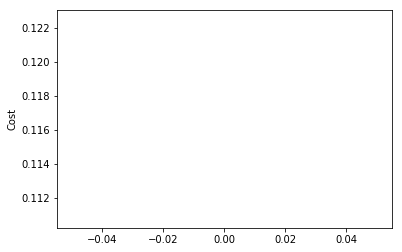

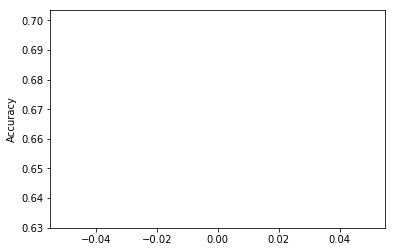

In [24]:
dataset = arff.loadarff('../data/weather.arff')
df = pd.DataFrame(dataset[0])

STR_COLUMNS = ['outlook', 'windy', 'play']

for column in STR_COLUMNS:
    df[column] = df[column].str.decode('utf-8')
    
df_encoded = pd.get_dummies(df, columns=['outlook', 'windy'])
df_encoded = pd.get_dummies(df_encoded, columns=['play'], drop_first=True)
df_encoded.temperature = df_encoded.temperature * 0.01
df_encoded.humidity = df_encoded.humidity * 0.01

X = df_encoded.iloc[:, :7].values
y = df_encoded.iloc[:, 7:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17779)

model = NeuralNetwork(input_nodes=7, hidden_nodes=[8], output_nodes=1, batch_size=1, learning_rate=0.1, momentum=0)
param, costs, accs = model.train(X_train, y_train, epochs=1)

print(param)
print()
print(costs)
print()
print(accs)

plt.plot(np.array(costs).mean(axis=1))
plt.ylabel('Cost')
plt.show()

plt.plot(accs)
plt.ylabel('Accuracy')
plt.show()

In [46]:
df = pd.read_csv('../data/train.csv')
df.fillna(df.median(), inplace=True)
X = df.drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked'])
y = X['Survived']
X = X.drop(columns=['Survived'])
X = pd.get_dummies(X, columns=['Sex'])

nn = NeuralNetwork(input_nodes=6,
                   hidden_nodes=[32, 32],
                   output_nodes=1,
                   batch_size=1,
                   learning_rate=1e-2,
                   momentum=0)

params, cost, accuracy = nn.train(X.values, y.values, epochs=1000)

# y_pred = nn.predict(X.values[0:10])
# print(y_pred)

Epoch 0/1000, Loss=0.11926388756195824, Accuracy=0.6094276094276094
Epoch 1/1000, Loss=0.11843062926473268, Accuracy=0.6161616161616161
Epoch 2/1000, Loss=0.11836417411430417, Accuracy=0.6161616161616161
Epoch 3/1000, Loss=0.11834346195256382, Accuracy=0.6161616161616161
Epoch 4/1000, Loss=0.11833228394231207, Accuracy=0.6161616161616161
Epoch 5/1000, Loss=0.11832442678551684, Accuracy=0.6161616161616161
Epoch 6/1000, Loss=0.11831925907854557, Accuracy=0.6161616161616161
Epoch 7/1000, Loss=0.11831604250873852, Accuracy=0.6161616161616161
Epoch 8/1000, Loss=0.11831416810081918, Accuracy=0.6161616161616161
Epoch 9/1000, Loss=0.11831308570454427, Accuracy=0.6161616161616161
Epoch 10/1000, Loss=0.11831327836555265, Accuracy=0.6161616161616161
Epoch 11/1000, Loss=0.11831318642845992, Accuracy=0.6161616161616161
Epoch 12/1000, Loss=0.11831295001868654, Accuracy=0.6161616161616161
Epoch 13/1000, Loss=0.11831293012964592, Accuracy=0.6161616161616161
Epoch 14/1000, Loss=0.11831336758633147, Acc

/home/rionaldichandraseta/miniconda3/envs/gemastik/lib/python3.6/site-packages/ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in exp


Epoch 44/1000, Loss=0.11832169919611514, Accuracy=0.6161616161616161
Epoch 45/1000, Loss=0.11832026723382941, Accuracy=0.6161616161616161
Epoch 46/1000, Loss=0.118320037100953, Accuracy=0.6161616161616161
Epoch 47/1000, Loss=0.11832039511310037, Accuracy=0.6161616161616161
Epoch 48/1000, Loss=0.11832234106782472, Accuracy=0.6161616161616161
Epoch 49/1000, Loss=0.1183212757229232, Accuracy=0.6161616161616161
Epoch 50/1000, Loss=0.11832179066062568, Accuracy=0.6161616161616161
Epoch 51/1000, Loss=0.11832202549531473, Accuracy=0.6161616161616161
Epoch 52/1000, Loss=0.11832253402387963, Accuracy=0.6161616161616161
Epoch 53/1000, Loss=0.11832273652328272, Accuracy=0.6161616161616161
Epoch 54/1000, Loss=0.11832323093706176, Accuracy=0.6161616161616161
Epoch 55/1000, Loss=0.11832350318338475, Accuracy=0.6161616161616161
Epoch 56/1000, Loss=0.11832390143818784, Accuracy=0.6161616161616161
Epoch 57/1000, Loss=0.11832407055927409, Accuracy=0.6161616161616161
Epoch 58/1000, Loss=0.118324504846260

Epoch 163/1000, Loss=0.11832729415311681, Accuracy=0.6161616161616161
Epoch 164/1000, Loss=0.11832499582276315, Accuracy=0.6161616161616161
Epoch 165/1000, Loss=0.11832510060261525, Accuracy=0.6161616161616161
Epoch 166/1000, Loss=0.11832489757234475, Accuracy=0.6161616161616161
Epoch 167/1000, Loss=0.11832482630576917, Accuracy=0.6161616161616161
Epoch 168/1000, Loss=0.1183246193784198, Accuracy=0.6161616161616161
Epoch 169/1000, Loss=0.11832453658989055, Accuracy=0.6161616161616161
Epoch 170/1000, Loss=0.1183243035444322, Accuracy=0.6161616161616161
Epoch 171/1000, Loss=0.11832418965756143, Accuracy=0.6161616161616161
Epoch 172/1000, Loss=0.11832383168091344, Accuracy=0.6161616161616161
Epoch 173/1000, Loss=0.11832371410312803, Accuracy=0.6161616161616161
Epoch 174/1000, Loss=0.11832339069586867, Accuracy=0.6161616161616161
Epoch 175/1000, Loss=0.11832309255675755, Accuracy=0.6161616161616161
Epoch 176/1000, Loss=0.11832281928318383, Accuracy=0.6161616161616161
Epoch 177/1000, Loss=0

Epoch 281/1000, Loss=0.11823504012950736, Accuracy=0.6161616161616161
Epoch 282/1000, Loss=0.11823291315222657, Accuracy=0.6161616161616161
Epoch 283/1000, Loss=0.11823327118385739, Accuracy=0.6161616161616161
Epoch 284/1000, Loss=0.11823436587971148, Accuracy=0.6161616161616161
Epoch 285/1000, Loss=0.11823051952506014, Accuracy=0.6161616161616161
Epoch 286/1000, Loss=0.11823176632028981, Accuracy=0.6161616161616161
Epoch 287/1000, Loss=0.11822672959863842, Accuracy=0.6161616161616161
Epoch 288/1000, Loss=0.11822771993709368, Accuracy=0.6161616161616161
Epoch 289/1000, Loss=0.1182306414102179, Accuracy=0.6161616161616161
Epoch 290/1000, Loss=0.11822917532303409, Accuracy=0.6161616161616161
Epoch 291/1000, Loss=0.11822812227637695, Accuracy=0.6161616161616161
Epoch 292/1000, Loss=0.11822978813353888, Accuracy=0.6161616161616161
Epoch 293/1000, Loss=0.11822870216549236, Accuracy=0.6161616161616161
Epoch 294/1000, Loss=0.11822897004870615, Accuracy=0.6161616161616161
Epoch 295/1000, Loss=

Epoch 399/1000, Loss=0.11818496941774158, Accuracy=0.6184062850729517
Epoch 400/1000, Loss=0.11818857992643943, Accuracy=0.6184062850729517
Epoch 401/1000, Loss=0.11818898527512094, Accuracy=0.6184062850729517
Epoch 402/1000, Loss=0.11819137470336244, Accuracy=0.6184062850729517
Epoch 403/1000, Loss=0.1181812355344911, Accuracy=0.6184062850729517
Epoch 404/1000, Loss=0.11818953344446965, Accuracy=0.6184062850729517
Epoch 405/1000, Loss=0.11818272052499947, Accuracy=0.6172839506172839
Epoch 406/1000, Loss=0.11818493485642546, Accuracy=0.6195286195286195
Epoch 407/1000, Loss=0.11818853886168842, Accuracy=0.6184062850729517
Epoch 408/1000, Loss=0.11817820915758659, Accuracy=0.6195286195286195
Epoch 409/1000, Loss=0.1181823439465473, Accuracy=0.6195286195286195
Epoch 410/1000, Loss=0.11818887094931413, Accuracy=0.6195286195286195
Epoch 411/1000, Loss=0.11817893344195352, Accuracy=0.6195286195286195
Epoch 412/1000, Loss=0.11818032319481038, Accuracy=0.6184062850729517
Epoch 413/1000, Loss=0

Epoch 518/1000, Loss=0.11811096824676151, Accuracy=0.6184062850729517
Epoch 519/1000, Loss=0.11811006048174756, Accuracy=0.6184062850729517
Epoch 520/1000, Loss=0.11810987593609047, Accuracy=0.6184062850729517
Epoch 521/1000, Loss=0.118107377173684, Accuracy=0.6184062850729517
Epoch 522/1000, Loss=0.11810621186417633, Accuracy=0.6184062850729517
Epoch 523/1000, Loss=0.11810620070863961, Accuracy=0.6184062850729517
Epoch 524/1000, Loss=0.1181041283077529, Accuracy=0.6184062850729517
Epoch 525/1000, Loss=0.11810235517456445, Accuracy=0.6184062850729517
Epoch 526/1000, Loss=0.11810206097831666, Accuracy=0.6184062850729517
Epoch 527/1000, Loss=0.1180997003058682, Accuracy=0.6184062850729517
Epoch 528/1000, Loss=0.11809847557783067, Accuracy=0.6184062850729517
Epoch 529/1000, Loss=0.11809757803253644, Accuracy=0.6184062850729517
Epoch 530/1000, Loss=0.11809586657051091, Accuracy=0.6184062850729517
Epoch 531/1000, Loss=0.11809425645036015, Accuracy=0.6184062850729517
Epoch 532/1000, Loss=0.1

Epoch 636/1000, Loss=0.11784598650105509, Accuracy=0.6195286195286195
Epoch 637/1000, Loss=0.11783969322154478, Accuracy=0.6195286195286195
Epoch 638/1000, Loss=0.11784027813281409, Accuracy=0.6195286195286195
Epoch 639/1000, Loss=0.11783694224112509, Accuracy=0.6195286195286195
Epoch 640/1000, Loss=0.11783082657784942, Accuracy=0.6195286195286195
Epoch 641/1000, Loss=0.11783319256039919, Accuracy=0.6195286195286195
Epoch 642/1000, Loss=0.11783086751207214, Accuracy=0.6195286195286195
Epoch 643/1000, Loss=0.11782733454112941, Accuracy=0.6195286195286195
Epoch 644/1000, Loss=0.11781653988425173, Accuracy=0.6195286195286195
Epoch 645/1000, Loss=0.11782134221169005, Accuracy=0.6195286195286195
Epoch 646/1000, Loss=0.11782003805899287, Accuracy=0.6195286195286195
Epoch 647/1000, Loss=0.11781710178087022, Accuracy=0.6195286195286195
Epoch 648/1000, Loss=0.11781474498495527, Accuracy=0.6195286195286195
Epoch 649/1000, Loss=0.11781150703583171, Accuracy=0.6206509539842873
Epoch 650/1000, Loss

Epoch 755/1000, Loss=0.1176228985708466, Accuracy=0.621773288439955
Epoch 756/1000, Loss=0.11762741715347501, Accuracy=0.621773288439955
Epoch 757/1000, Loss=0.11762601817778032, Accuracy=0.621773288439955
Epoch 758/1000, Loss=0.1176288938815914, Accuracy=0.621773288439955
Epoch 759/1000, Loss=0.11762705809571537, Accuracy=0.621773288439955
Epoch 760/1000, Loss=0.11762483033842186, Accuracy=0.621773288439955
Epoch 761/1000, Loss=0.1176259353277912, Accuracy=0.621773288439955
Epoch 762/1000, Loss=0.11762218936940771, Accuracy=0.621773288439955
Epoch 763/1000, Loss=0.11762417034395799, Accuracy=0.621773288439955
Epoch 764/1000, Loss=0.11761962422913719, Accuracy=0.621773288439955
Epoch 765/1000, Loss=0.11762059243051468, Accuracy=0.621773288439955
Epoch 766/1000, Loss=0.11761793660426001, Accuracy=0.621773288439955
Epoch 767/1000, Loss=0.11761720507087778, Accuracy=0.621773288439955
Epoch 768/1000, Loss=0.11761517788532254, Accuracy=0.621773288439955
Epoch 769/1000, Loss=0.11761607634201

Epoch 874/1000, Loss=0.1174854329384668, Accuracy=0.622895622895623
Epoch 875/1000, Loss=0.11748437205693213, Accuracy=0.6240179573512907
Epoch 876/1000, Loss=0.1174832787182288, Accuracy=0.6240179573512907
Epoch 877/1000, Loss=0.11748245387827963, Accuracy=0.6240179573512907
Epoch 878/1000, Loss=0.11748063632591396, Accuracy=0.6240179573512907
Epoch 879/1000, Loss=0.11748019733216473, Accuracy=0.622895622895623
Epoch 880/1000, Loss=0.11747880860546416, Accuracy=0.6240179573512907
Epoch 881/1000, Loss=0.11747715389671906, Accuracy=0.622895622895623
Epoch 882/1000, Loss=0.11747637890018904, Accuracy=0.6240179573512907
Epoch 883/1000, Loss=0.11747480526775225, Accuracy=0.622895622895623
Epoch 884/1000, Loss=0.11747345797403602, Accuracy=0.6240179573512907
Epoch 885/1000, Loss=0.11747253315774756, Accuracy=0.622895622895623
Epoch 886/1000, Loss=0.11747111689324083, Accuracy=0.6240179573512907
Epoch 887/1000, Loss=0.11746902640341658, Accuracy=0.622895622895623
Epoch 888/1000, Loss=0.11746

Epoch 993/1000, Loss=0.11740171315479357, Accuracy=0.6240179573512907
Epoch 994/1000, Loss=0.11733982822515754, Accuracy=0.6240179573512907
Epoch 995/1000, Loss=0.11739345003929513, Accuracy=0.6240179573512907
Epoch 996/1000, Loss=0.11731915082726185, Accuracy=0.6240179573512907
Epoch 997/1000, Loss=0.11733260727256013, Accuracy=0.622895622895623
Epoch 998/1000, Loss=0.11733249901053618, Accuracy=0.622895622895623
Epoch 999/1000, Loss=0.11733908938906255, Accuracy=0.622895622895623
